# Adversarial Attack

This notebook implements the adversial attack presented in the *framing-trustworthy-ai-lifecycle* guide on the Responsible AI GitHub repo [https://github.com/microsoft/responsible-ai-workshop].


To avoid any problems when using this notebook, please refer to the instructions and technical documentation in the associated document.


If it's your first time using a notebook or a notebook associeted to our repo, please read the **Prerequisites Guides**.

If you want to run it, you will also need to read the note:
- [getting-started-with-azure](https://github.com/microsoft/responsible-ai-workshop/blob/main/perequisites/getting-started-with-azure.md)
- [using-jupyter-notebook-in-azure-data-studio](https://github.com/microsoft/responsible-ai-workshop/blob/main/perequisites/using-jupyter-notebooks-in-azure-data-studio.md)
- [leveraging-counterfit](https://github.com/microsoft/responsible-ai-workshop/blob/main/perequisites/leveraging-counterfit.md)

**Notes**: 
- We highly recomand you to use AzureML Notebook for the training of the model if you don't have a comptuer with a GPU. 
- We recommand you to use Counterfit on your computer due to Docker issues within Azure




## Dowload libraries

Run the following cell to download the libraries needed to run this notebook

In [5]:
%pip install keras
%pip install kagglehub
%pip install tensorflow
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Import

In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import keras
from keras.optimizers import Adam
import kagglehub
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import accuracy_score

## Dowload Dataset

Run this cell to dowload the Dataset to train the model

In [4]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\t-vverdon\.cache\kagglehub\datasets\meowmeowmeowmeowmeow\gtsrb-german-traffic-sign\versions\1


## Load the Train Dataset

The Dataset is already separate into Train & Test dataset. 

We will load the train data and set the different parameters for the training

In [5]:
BATCH_SIZE = 32
NUM_CATEGORIES = 43
height, width, channels = 30, 30, 3

In [23]:
# Load the images
train_path = path + "/Train"

def load_data(data_dir):
    images = []
    labels = []
    for class_folder in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_folder)
        for image_file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, image_file))
            img = cv2.resize(img, (height, width))
            images.append(img)
            labels.append(int(class_folder))
    return np.array(images), np.array(labels)

X_train, y_train = load_data(train_path)
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [24]:
# Create  Generators for the training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.2
)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    subset='validation'
)

## Create & Train the model

First, we create the model architecture

In [44]:
model = keras.models.Sequential([ 
    keras.layers.InputLayer(shape=(height, width, channels)),   
    keras.layers.Conv2D(filters=BATCH_SIZE, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
])
opt = Adam()
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [45]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 9, 9, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,891 (573.79 KB)

 Trainable params: 146,443 (572.04 KB)

 Non-trainable params: 448 (1.75 KB)

Now, we can train our model

In [46]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.3245 - loss: 2.7595 - val_accuracy: 0.8569 - val_loss: 0.4686
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.8709 - loss: 0.4491 - val_accuracy: 0.9557 - val_loss: 0.1690
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9412 - loss: 0.2033 - val_accuracy: 0.9379 - val_loss: 0.2127
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.9552 - loss: 0.1544 - val_accuracy: 0.9667 - val_loss: 0.1039
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9683 - loss: 0.1067 - val_accuracy: 0.9833 - val_loss: 0.0506
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.9742 - loss: 0.0839 - val_accuracy: 0.9379 - val_loss: 0.1979
Epoch 7/30
981/9

Let's check that our model has been properly trained

In [47]:
training_accuracy = history.history["accuracy"]
training_loss = history.history["loss"]
validation_accuracy = history.history["val_accuracy"]
validation_loss = history.history["val_loss"]

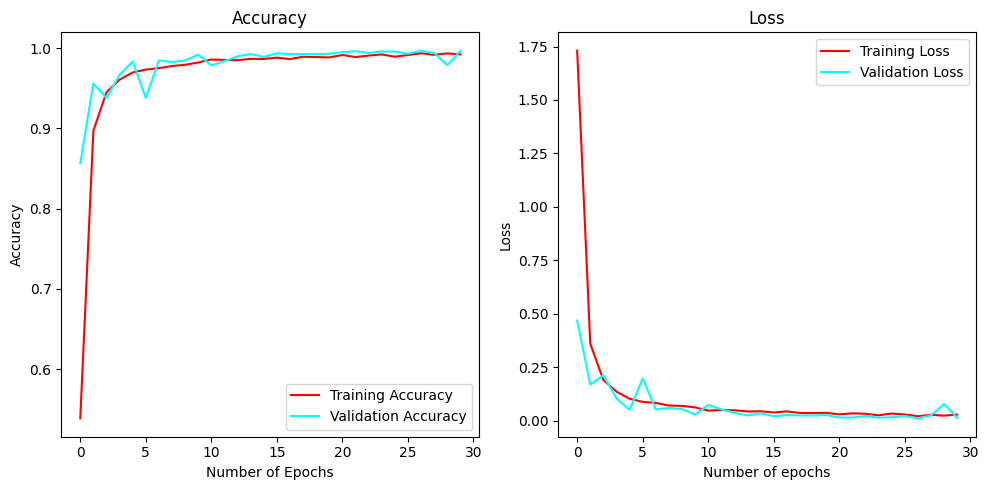

In [48]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, color = "red", label = "Training Accuracy")
plt.plot(validation_accuracy, color = "cyan", label = "Validation Accuracy")
plt.legend()
plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(training_loss, color = "red", label = "Training Loss")
plt.plot(validation_loss, color = "cyan", label = "Validation Loss")
plt.legend()
plt.title("Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()

Let's try it with our Test Dataset

In [6]:
def load_test_data(test_df):
    images = []
    for path in test_df["Path"]:
        img = cv2.imread(path)
        img = cv2.resize(img, (width, height))
        images.append(img)
    return np.array(images)

In [7]:
test_path = path +"/Test.csv"
test_df = pd.read_csv(test_path)
test_df.columns = ["Width", "Height", "Roi.X1", "Roi.Y1", "Roi.X2", "Roi.Y2", "ClassId", "Path"]
test_df['Path'] = test_df['Path'].apply(lambda x: os.path.join(path, x.strip()))
X_test = load_test_data(test_df)
X_test = X_test / 255.0

In [11]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

test_df = pd.read_csv(test_path)
true_labels = test_df["ClassId"].values

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test accuracy: {accuracy * 100:.4f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Test accuracy: 97.7435%


## Save & Load the model

Let's save the model if we want to use it latter without retraining it !

In [52]:
model.save("model.keras")

Try to load it. It can be done in another computer with just this line and the associated model:

In [3]:
model = keras.saving.load_model("model.keras")

## Counterfit part (create the adversial attack)

This part use the Counterfit library in a command line system. Please follow the instruction in the associated guide to process the attack on our model.

**Note**: At the time of writing (23.10.2024), the attack on traffic signs is no more available on Counterfit. However, you can try with another type of images listed here: [link](https://github.com/Azure/counterfit/wiki/Basic-Use).


You will just have to retrain a model with these data, no change is needed, and then generate your own attack with counterfit.


You can use your attack in the next part and check if it's worked !

## Test the Attack

In [8]:
img = cv2.imread("image.png")
img = cv2.resize(img, (width, height))
img = img / 255.0
np.argmax(model.predict(np.array([img])), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([14], dtype=int64)